# Сентимент-анализ отзывов на товары

https://inclass.kaggle.com/c/product-reviews-sentiment-analysis-light

Классифицируйте отзывы по тональности

In [56]:
import re
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

Читаем данные

In [57]:
train = pd.read_csv("data/products_sentiment_train.tsv", sep='\t')
test = pd.read_csv("data/products_sentiment_test.tsv", sep='\t')

In [58]:
train.head()

,text,grade
0,"take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [59]:
test.head()

,Id,text
0,0,"so , why the small digital elph , rather than ..."
1,1,3/4 way through the first disk we played on it...
2,2,better for the zen micro is outlook compatibil...
3,3,6 . play gameboy color games on it with goboy .
4,4,"likewise , i 've heard norton 2004 professiona..."


Каков размер

In [60]:
print('Size of train:', train.shape[0])
print('Size of test:', test.shape[0])

Size of train: 2000
Size of test: 500


Сравним количество позитивных и негативных

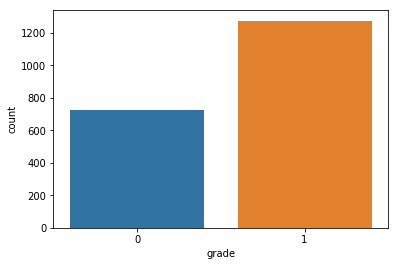

In [61]:
sb.countplot(x='grade', data=train)

Видим, что есть перекос в сторону позитивных отзывов

Создадим общий список отзывов

In [62]:
reviews = pd.concat([train, test], axis=0)

In [63]:
vectorizer = CountVectorizer()
vectorizer.fit(reviews['text'])
X_train_vect = vectorizer.transform(train['text'])
X_test_vect = vectorizer.transform(test['text'])
X_train_vect.shape

(2000, 4488)

Количество уникальных слов (фич)

In [64]:
quantity_of_features = len(vectorizer.get_feature_names())
print(quantity_of_features)

4488


Отделим "ответы" от текстов

In [65]:
y = train['grade']

Запустим простую регрессию

In [66]:
log_reg = LogisticRegression(C=1)
results = cross_val_score(log_reg, X_train_vect, y, cv=3)
print(results)

[0.7916042  0.74212894 0.78828829]


In [67]:
def save_result(prediction, file_name):
    pd.DataFrame({"Id":list(range(0, 500)),"y":prediction}).to_csv(file_name, index=False, header=True)
log_reg.fit(X_train_vect, y)
save_result(log_reg.predict(X_test_vect), 'result.csv')

ШТОШ. Перейдем к тяжелой артиллерии

In [246]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews['text'])

X_train = tokenizer.texts_to_sequences(np.array(train['text']))
X_test = tokenizer.texts_to_sequences(np.array(test['text']))

train_split, test_split, y_train_split, y_test_split = train_test_split(X_train, y, 
                                                                        test_size=0.1, random_state=42)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(train_split[2])
print(X_train[2])
print(vocab_size)

[3, 1157, 13, 1, 127, 433, 640, 2, 851, 21, 65, 282, 2, 81, 65, 86]
[1, 687, 351, 1, 2303, 7, 6, 202, 2304, 37, 12, 143, 313, 1303, 14, 6, 1304, 487, 40, 11, 6, 145, 2305, 760, 20, 23, 19, 169]
4524


In [254]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, GlobalMaxPooling1D

maxlen = 100
embedding_dim = 64

train_split = pad_sequences(train_split, padding='post', maxlen=maxlen)
test_split = pad_sequences(test_split, padding='post', maxlen=maxlen)
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(train_split[2, :])

[   3 1157   13    1  127  433  640    2  851   21   65  282    2   81
   65   86    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [266]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_59 (Embedding)     (None, 100, 64)           289536    
_________________________________________________________________
global_max_pooling1d_35 (Glo (None, 64)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 11        
Total params: 290,197
Trainable params: 290,197
Non-trainable params: 0
_________________________________________________________________


Если что, результаты ниже уже боевые, до этого сетка подгонялась на кросс-валидации

Train on 2000 samples, validate on 200 samples
Epoch 1/6
2000/2000 [==============================] - 1s - loss: 0.6641 - acc: 0.6375 - val_loss: 0.5979 - val_acc: 0.7300
Epoch 2/6
2000/2000 [==============================] - 0s - loss: 0.6317 - acc: 0.6370 - val_loss: 0.5562 - val_acc: 0.7300
Epoch 3/6
2000/2000 [==============================] - 0s - loss: 0.5779 - acc: 0.6635 - val_loss: 0.4662 - val_acc: 0.8150
Epoch 4/6
2000/2000 [==============================] - 0s - loss: 0.4598 - acc: 0.8190 - val_loss: 0.3317 - val_acc: 0.9250
Epoch 5/6
2000/2000 [==============================] - 0s - loss: 0.3210 - acc: 0.9125 - val_loss: 0.2260 - val_acc: 0.9450
Epoch 6/6
2000/2000 [==============================] - 0s - loss: 0.2204 - acc: 0.9425 - val_loss: 0.1621 - val_acc: 0.9700
Training Accuracy: 0.9661
Testing Accuracy:  0.9700


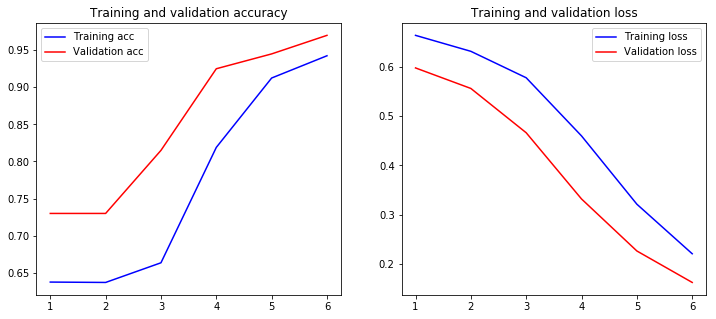

In [267]:
history = model.fit(X_train, y,
                    epochs=6,
                    validation_data=(test_split, y_test_split))
loss, accuracy = model.evaluate(train_split, y_train_split, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(test_split, y_test_split, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [268]:
prediction = np.around(model.predict(X_test), decimals=0)
save_result(prediction[:,0].astype(int), 'result_nn.csv')

Финальный результат!
![title](final_score.png)